In [71]:
!pip install seaborn


     |████████████████████████████████| 292 kB 1.1 MB/s eta 0:00:01


In [239]:
# Package imports
import inspect, os, sys
from datetime import datetime, timedelta, date
import calendar
import itertools
import pandas as pd
from pandas import IndexSlice as idx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
import random
import math

import seaborn as sns

# Suppress warnings
import logging, sys
logging.disable(sys.maxsize)

# Data preparation

In [2]:
# Define a function that reads and appends chunks:
def read_csv_chunk(csv_file, var_list):
    data_iterator = pd.read_csv(csv_file, chunksize=100000, usecols=var_list)
    
    chunk_list = []
    # Each chunk is in dataframe format
    for data_chunk in data_iterator:  
        consolidated_chunk = data_chunk.drop_duplicates()
        chunk_list.append(consolidated_chunk)
    return pd.concat(chunk_list)

In [3]:
import time
start_time = time.time()

In [4]:
# Construct base group
Oct_user = read_csv_chunk("../Data/2019-Oct.csv", ['user_id']).drop_duplicates()
Nov_user = read_csv_chunk("../Data/2019-Nov.csv", ['user_id']).drop_duplicates()
Dec_user = read_csv_chunk("../Data/2019-Dec.csv", ['user_id']).drop_duplicates()

base_user = pd.concat([Oct_user, Nov_user, Dec_user]).drop_duplicates()


In [5]:
# Construct comparison group
Jan_user = read_csv_chunk("../Data/2020-Jan.csv", ['user_id']).drop_duplicates()
Feb_user = read_csv_chunk("../Data/2020-Feb.csv", ['user_id']).drop_duplicates()
Mar_user = read_csv_chunk("../Data/2020-Mar.csv", ['user_id']).drop_duplicates()

comp_user = pd.concat([Jan_user, Feb_user, Mar_user]).drop_duplicates()

print("--- %s seconds ---" % (time.time() - start_time))

--- 1037.1827914714813 seconds ---


In [7]:
# User returning rate from 2019Q4 to 2020Q1
print('Base total user: {}; Base user who returned in 2020: {}; Returning rate from 2019Q4 to 2020Q1: {}%' \
        .format(len(base_user), len(np.intersect1d(base_user["user_id"], comp_user["user_id"])), \
                100*len(np.intersect1d(base_user["user_id"], comp_user["user_id"]))/len(base_user)))

Base total user: 7856638; Base user who returned in 2020: 3289073; Returning rate from 2019Q4 to 2020Q1: 41.86361901872022%


In [9]:
# Save monthly user list
Oct_user.to_csv('Oct_user.csv')
Nov_user.to_csv('Nov_user.csv')
Dec_user.to_csv('Dec_user.csv')
Jan_user.to_csv('Jan_user.csv')
Feb_user.to_csv('Feb_user.csv')
Mar_user.to_csv('Mar_user.csv')

In [8]:
# Save user list
base_user.to_csv('base_user.csv')
comp_user.to_csv('comp_user.csv')


In [13]:
del Oct_user, Nov_user, Dec_user, Jan_user, Feb_user, Mar_user

# Sample data

In [2]:
base_user = pd.read_csv('base_user.csv', index_col=0)
comp_user = pd.read_csv('comp_user.csv', index_col=0)

In [3]:
# Sample X% of base users for processing
perc = 0.05
select_num = random.sample(range(len(base_user)), math.ceil(len(base_user)*perc))
base_user_selected = base_user.iloc[select_num, 0]

In [4]:
# Define a function that reads and appends chunks:
def read_csv_filtered(csv_file, filter_ls):
    data_iterator = pd.read_csv(csv_file, chunksize=100000)
    
    chunk_list = []
    # Each chunk is in dataframe format
    for data_chunk in data_iterator:  
        filtered_chunk = data_chunk[data_chunk.user_id.isin(filter_ls)]
        chunk_list.append(filtered_chunk)

    return pd.concat(chunk_list)

In [5]:
df_sample = pd.DataFrame()
for f in ['Oct', 'Nov', 'Dec']:
    df = read_csv_filtered(f'../Data/2019-{f}.csv', base_user_selected)
    df_sample = pd.concat([df_sample, df], ignore_index=True)

In [6]:
assert df_sample.user_id.isin(base_user_selected).sum() == len(df_sample)

In [7]:
# Add a column indicating if the user returns in Nov
df_sample['f_retention'] = df_sample.user_id.isin(comp_user['user_id']).astype(int)

In [435]:
df_sample.to_csv(f"../Data/2019-Q4-sample-{perc*100}%.csv", index=False)

In [64]:
print('Sample data has {} rows of {} users'.format(df_sample.shape[0], df_sample.user_id.nunique()))

Sample data has 8913183 rows of 392832 users


# Feature engineering (sample)

In [67]:
df_sample[['user_id', 'f_retention']].drop_duplicates().f_retention.value_counts(normalize=True).iloc[1]

0.42004470104268493

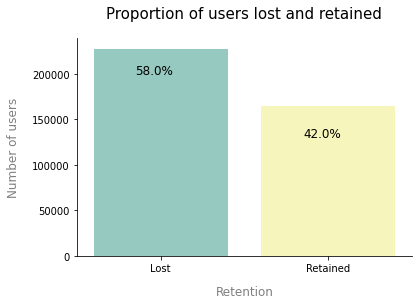

In [330]:
# df_sample[['user_id', 'f_retention']].drop_duplicates().f_retention.value_counts(normalize=True)
num_user_retained = 100.00 * df_sample[['user_id', 'f_retention']].drop_duplicates().f_retention.value_counts(normalize=True).iloc[1]
num_user_lost = 100.00 * df_sample[['user_id', 'f_retention']].drop_duplicates().f_retention.value_counts(normalize=True).iloc[0]

sns.countplot(x='f_retention', palette="Set3", data=df_sample[['user_id', 'f_retention']].drop_duplicates())
plt.xticks([0, 1], ['Lost', 'Retained'])
plt.xlabel('Retention', size=12, labelpad=12, color='grey')
plt.ylabel('Number of users', size=12, labelpad=12, color='grey')
plt.title("Proportion of users lost and retained", size=15, pad=20)
# plt.ylim(0, 9000)
plt.text(-0.15, 200000, f"{round(num_user_lost, 2)}%", fontsize=12)
plt.text(0.85, 130000, f"{round(num_user_retained, 2)}%", fontsize=12)
sns.despine()
plt.savefig('../Fig/User retention rate.png', bbox_inches="tight")

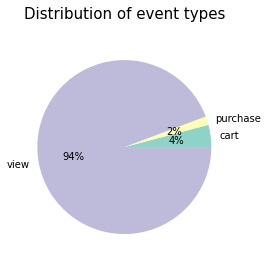

In [260]:
event_typ = df_sample.groupby('event_type', dropna=False).size()
colors = sns.color_palette('Set3')[0:len(event_typ)]

#create pie chart
plt.pie(event_typ, labels = event_typ.index, colors = colors, autopct='%.0f%%');
plt.title("Distribution of event types", size=15, pad=20);
plt.savefig('../Fig/Event type distribution.png', bbox_inches="tight")

In [96]:
print('Activities involve {} products and {} categories'.format(df_sample.product_id.nunique(), df_sample.category_id.nunique()))

Activities involve 172470 products and 1196 categories


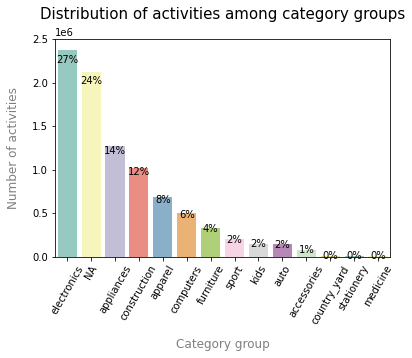

In [142]:
# Category group
cat_typ = df_sample.groupby('category_code_first', dropna=False).size().sort_values(ascending=False)

fig, ax = plt.subplots()

sns.barplot(x=cat_typ.index, y=cat_typ, data=pd.DataFrame(cat_typ), palette='Set3');
plt.xticks(rotation=60);
plt.xlabel('Category group', size=12, labelpad=12, color='grey')
plt.ylabel('Number of activities', size=12, labelpad=12, color='grey')
plt.title("Activity distribution among category groups", size=15, pad=20)

perc_label = cat_typ / cat_typ.sum(axis=0)
for i, rect in enumerate(ax.patches):
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height*0.95
    ax.text(label_x, label_y, '{:.0%}'.format(perc_label[i]), ha='center', va='center', color = 'black')

plt.savefig('../Fig/Category distribution.png', bbox_inches="tight")

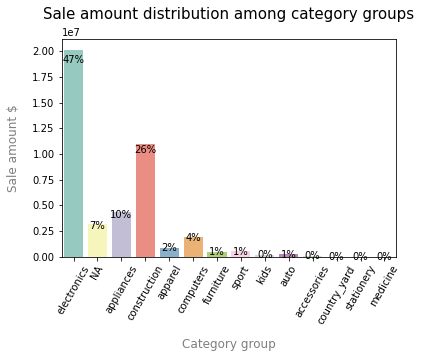

In [192]:
# Category group
sale_cat_typ = df_sample[df_sample.event_type=='purchase'].groupby(['category_code_first'], dropna=False).price.sum().reindex(cat_typ.index)

fig, ax = plt.subplots()

sns.barplot(x=sale_cat_typ.index, y=sale_cat_typ, data=pd.DataFrame(sale_cat_typ), palette='Set3');
plt.xticks(rotation=60);
plt.xlabel('Category group', size=12, labelpad=12, color='grey')
plt.ylabel('Sale amount $', size=12, labelpad=12, color='grey')
plt.title("Sale amount distribution among category groups", size=15, pad=20)

perc_label = sale_cat_typ / sale_cat_typ.sum(axis=0)
for i, rect in enumerate(ax.patches):
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height*0.95
    ax.text(label_x, label_y, '{:.0%}'.format(perc_label[i]), ha='center', va='center', color = 'black')

plt.savefig('../Fig/Category distribution in terms of sale.png', bbox_inches="tight")

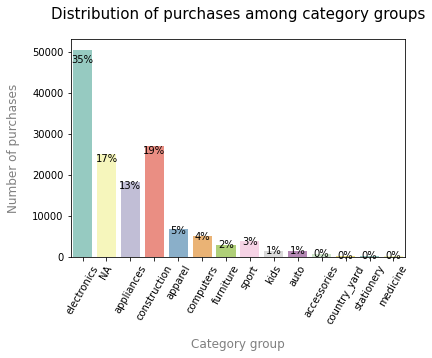

In [179]:
# Category group
purchase_cat_typ = df_sample[df_sample.event_type=='purchase'].groupby('category_code_first', dropna=False).size().reindex(cat_typ.index)

fig, ax = plt.subplots()

sns.barplot(x=purchase_cat_typ.index, y=purchase_cat_typ, data=pd.DataFrame(purchase_cat_typ), palette='Set3');
plt.xticks(rotation=60);
plt.xlabel('Category group', size=12, labelpad=12, color='grey')
plt.ylabel('Number of purchases', size=12, labelpad=12, color='grey')
plt.title("Sale quantity distribution among category groups", size=15, pad=20)

perc_label = purchase_cat_typ / purchase_cat_typ.sum(axis=0)
for i, rect in enumerate(ax.patches):
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height*0.95
    ax.text(label_x, label_y, '{:.0%}'.format(perc_label[i]), ha='center', va='center', color = 'black')

plt.savefig('../Fig/Category distribution in terms of purchases.png', bbox_inches="tight")

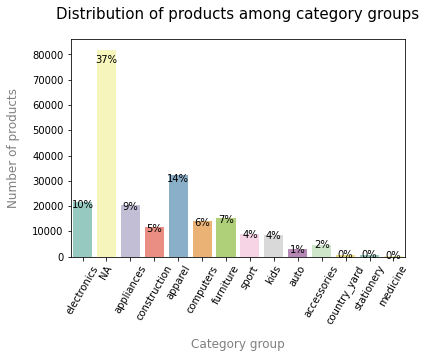

In [178]:
# Category group
product_cat_typ = df_sample.groupby('category_code_first', dropna=False).product_id.nunique().reindex(cat_typ.index)

fig, ax = plt.subplots()

sns.barplot(x=product_cat_typ.index, y=product_cat_typ, data=pd.DataFrame(product_cat_typ), palette='Set3');
plt.xticks(rotation=60);
plt.xlabel('Category group', size=12, labelpad=12, color='grey')
plt.ylabel('Number of products', size=12, labelpad=12, color='grey')
plt.title("Distribution of products among category groups", size=15, pad=20)

perc_label = product_cat_typ / product_cat_typ.sum(axis=0)
for i, rect in enumerate(ax.patches):
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height*0.95
    ax.text(label_x, label_y, '{:.0%}'.format(perc_label[i]), ha='center', va='center', color = 'black')

plt.savefig('../Fig/Category distribution in terms of products.png', bbox_inches="tight")

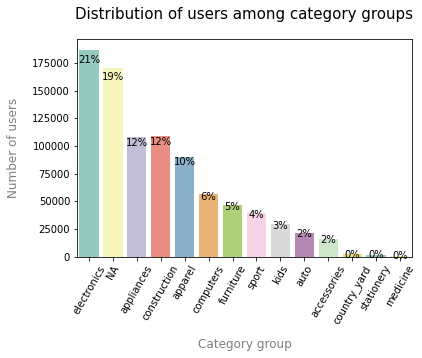

In [250]:
# Category group
user_cat_typ = df_sample.groupby('category_code_first', dropna=False).user_id.nunique().reindex(cat_typ.index)

fig, ax = plt.subplots()

sns.barplot(x=user_cat_typ.index, y=user_cat_typ, data=pd.DataFrame(user_cat_typ), palette='Set3');
plt.xticks(rotation=60);
plt.xlabel('Category group', size=12, labelpad=12, color='grey')
plt.ylabel('Number of users', size=12, labelpad=12, color='grey')
plt.title("Distribution of users among category groups", size=15, pad=20)

perc_label = user_cat_typ / user_cat_typ.sum(axis=0)
for i, rect in enumerate(ax.patches):
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height*0.95
    ax.text(label_x, label_y, '{:.0%}'.format(perc_label[i]), ha='center', va='center', color = 'black')

plt.savefig('../Fig/Category distribution in terms of users.png', bbox_inches="tight")

In [131]:
df_sample['event_date'] = pd.to_datetime(df_sample['event_time'].str[:10])

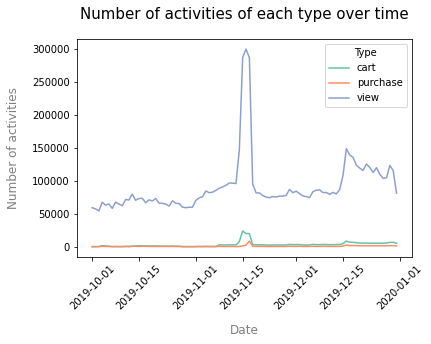

In [232]:
sns.lineplot(data=df_sample.groupby(['event_date', 'event_type']).size().unstack('event_type'), \
             palette='Set2', dashes=False)
plt.xlabel('Date', size=12, labelpad=12, color='grey')
plt.ylabel('Number of activities', size=12, labelpad=12, color='grey')
plt.title("Number of activities of each type over time", size=15, pad=20);
plt.legend(title='Type');
plt.xticks(rotation=45);
plt.savefig('../Fig/Activities over time.png',  bbox_inches="tight")

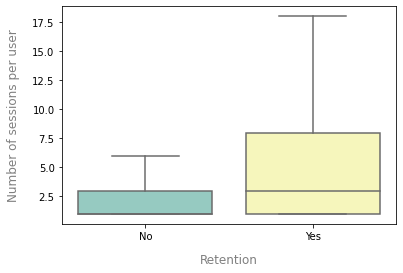

In [261]:
sns.boxplot(x='f_retention', y='user_session', palette='Set3', \
            data=df_sample.groupby(['user_id', 'f_retention'])['user_session'].nunique().reset_index(), \
            showfliers = False
           )

plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

plt.xlabel('Retention', size=12, labelpad=12, color='grey');
plt.ylabel('Number of sessions per user', size=12, labelpad=12, color='grey');

plt.savefig('../Fig/Boxplot of session counts by class.png', bbox_inches="tight")

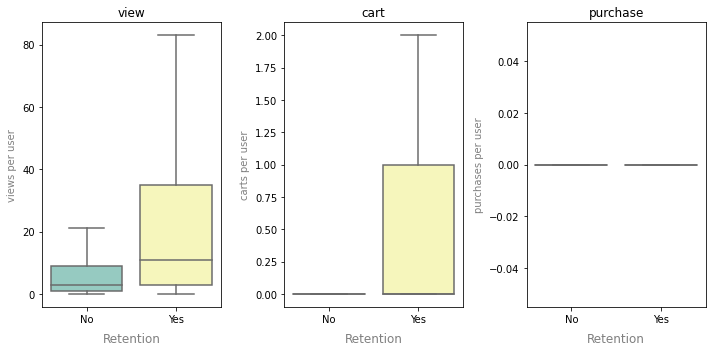

In [262]:
event_type_ls = df_sample.event_type.unique()
fig, ax = plt.subplots(1, len(event_type_ls), figsize=(10, 5))
for i in range(len(event_type_ls)):
    a = ax[i]
    sns.boxplot(x='f_retention', y=f'{event_type_ls[i]}', palette='Set3', \
                data=df_sample.groupby(['user_id', 'f_retention', 'event_type']).size().unstack('event_type').fillna(0).reset_index(), \
                showfliers = False, ax=a
               )

    a.set_xticklabels(labels=['No', 'Yes'])

    a.set_xlabel('Retention', size=12, labelpad=8, color='grey');
    a.set_ylabel(f'{event_type_ls[i]}s per user', size=10, labelpad=5, color='grey');
    a.set_title(f'{event_type_ls[i]}')

plt.tight_layout()    
plt.savefig('../Fig/Boxplot of event counts by class.png', bbox_inches="tight")

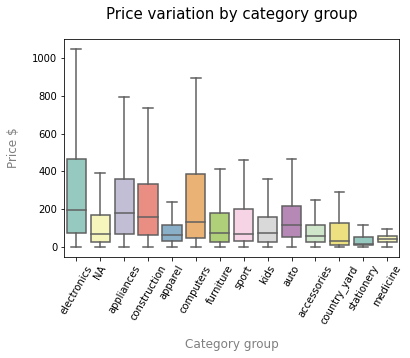

In [203]:
sns.boxplot(x='category_code_first', y='price', palette='Set3', \
            data=df_sample.loc[df_sample.event_type=='view', ['category_code_first', 'product_id', 'price']].drop_duplicates(), \
            showfliers = False,
            order = cat_typ.index
           )

plt.xlabel('Category group', size=12, labelpad=12, color='grey');
plt.ylabel('Price $', size=12, labelpad=12, color='grey');
plt.xticks(rotation=60);
plt.title('Price variation by category group', size=15, pad=20);
plt.savefig('../Fig/Price variation by category group.png', bbox_inches="tight")

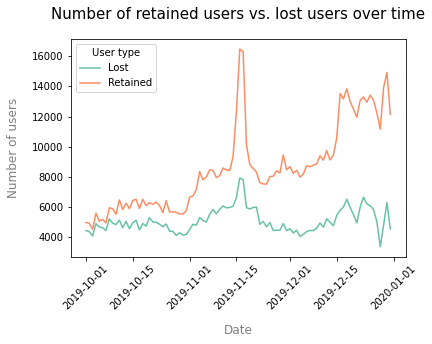

In [226]:
sns.lineplot(data=df_sample.groupby(['event_date', 'f_retention']).user_id.nunique().unstack('f_retention'), palette='Set2', dashes=False)
plt.xlabel('Date', size=12, labelpad=12, color='grey')
plt.ylabel('Number of users', size=12, labelpad=12, color='grey')
plt.title("Number of retained users vs. lost users over time", size=15, pad=20);
plt.xticks(rotation=45);
plt.legend(title='User type', labels=['Lost', 'Retained']);
plt.savefig('../Fig/Number of users over time.png', bbox_inches="tight")

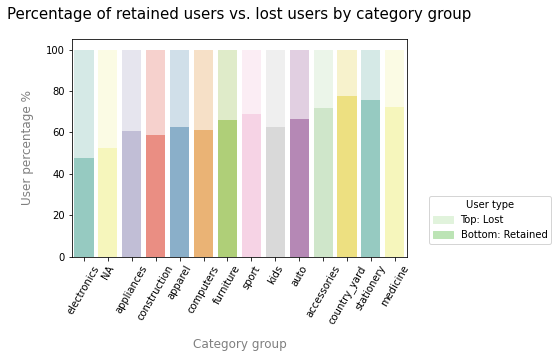

In [248]:
user_by_cat = df_sample.groupby(['category_code_first', 'f_retention']).user_id.nunique().unstack('f_retention').reindex(cat_typ.index)
user_by_cat['perc_retained'] = user_by_cat[1] / user_by_cat[[0,1]].sum(axis=1) * 100
user_by_cat['total_perc'] = 100

# top bars
bar1 = sns.barplot(x=user_by_cat.index, y="total_perc", data=user_by_cat, palette='Set3', alpha=0.4)

# bottom bars
bar2 = sns.barplot(x=user_by_cat.index, y="perc_retained", data=user_by_cat, palette='Set3')

# add legend
top_bar = mpatches.Patch(color='#e1f3dc', label='Top: Lost')
bottom_bar = mpatches.Patch(color='#bce4b5', label='Bottom: Retained')
plt.legend(title='User type', handles=[top_bar, bottom_bar], bbox_to_anchor=(1.05, 0.3));

# Add other elements
plt.xticks(rotation=60);
plt.xlabel('Category group', size=12, labelpad=12, color='grey')
plt.ylabel('User percentage %', size=12, labelpad=12, color='grey')
plt.title("Percentage of retained users vs. lost users by category group", size=15, pad=20);

plt.savefig('../Fig/Retained user percentage by category group.png', bbox_inches="tight")

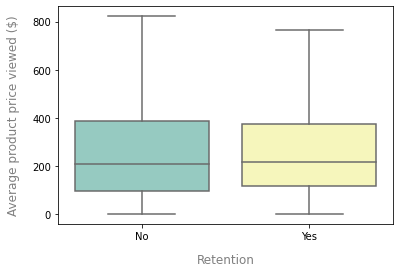

In [283]:
sns.boxplot(x='f_retention', y='view', palette='Set3', \
            data=df_sample.groupby(['user_id', 'f_retention', 'event_type'])['price'].mean().unstack('event_type')[['view', 'cart', 'purchase']].bfill(axis=1).iloc[:, 0].reset_index(), \
            showfliers = False
           )

plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

plt.xlabel('Retention', size=12, labelpad=12, color='grey');
plt.ylabel('Average product price viewed ($)', size=12, labelpad=12, color='grey');

plt.savefig('../Fig/Average product price by class.png', bbox_inches="tight")

# Feature construction

In [251]:
# Collapse to user level
df = df_sample[['user_id', 'f_retention']].drop_duplicates().set_index(['user_id', 'f_retention'])

In [252]:
# Number of views and carts per user
num_event_per_user = df_sample.groupby(['user_id', 'f_retention', 'event_type']).size().unstack('event_type').fillna(0).drop(labels='purchase', axis=1)
col_names = ['num_' + col for col in num_event_per_user.columns]
df[col_names] = num_event_per_user

In [254]:
# Number of sessions per user
df['num_session'] = df_sample.groupby(['user_id', 'f_retention'])['user_session'].nunique()

In [255]:
# Number of days between the first and last activity of the user
def min_max_days(s):
    return (s.max() - s.min()).days + 1
df['tenure'] = df_sample.groupby(['user_id', 'f_retention']).agg({'event_date': min_max_days})

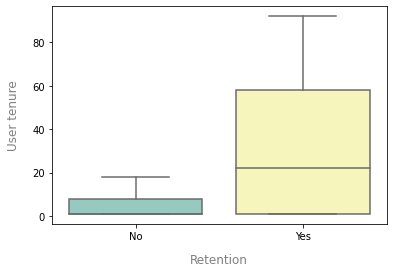

In [258]:
sns.boxplot(x='f_retention', y='tenure', palette='Set3', \
            data=df.reset_index(), \
            showfliers = False
           )

plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

plt.xlabel('Retention', size=12, labelpad=12, color='grey');
plt.ylabel('User tenure', size=12, labelpad=12, color='grey');

plt.savefig('../Fig/Boxplot of tenure by class.png', bbox_inches="tight")

In [275]:
# Dummy variable indicating if a user has any event on a certain date
col_names =['f_event_' + str(col) for col in df_sample.event_date.dt.date.unique()]

df[col_names] = \
    df_sample[['user_id', 'f_retention', 'event_date']].drop_duplicates() \
    .groupby(['user_id', 'f_retention', 'event_date']).size().unstack('event_date').fillna(0)

In [276]:
# Dummy variable indicating if a user checks a certain category group
col_names =['f_event_' + str(col) for col in df_sample.category_code_first.unique()]

df[col_names] = \
    df_sample[['user_id', 'f_retention', 'category_code_first']].drop_duplicates() \
    .groupby(['user_id', 'f_retention', 'category_code_first']).size().unstack('category_code_first').fillna(0)


# Number of unique categories viewed, added to cart, or purchased
# df['num_category_checked'] = df_sample.groupby(['user_id', 'f_retention']).agg({'category_id': 'nunique'})

/home/nonroott/.local/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [263]:
# Whether user has items in the cart at the end of Q4, i.e. has "cart" activity not followed by purchase
latest_event = df_sample.groupby(['user_id', 'f_retention', 'event_type'])['event_time'].max().unstack('event_type')
df['f_cart_not_empty'] = (latest_event['purchase'] < latest_event['cart']).astype(int)

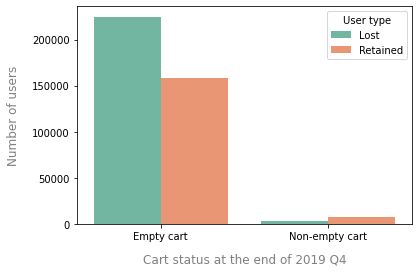

In [274]:
sns.countplot(x='f_cart_not_empty', hue='f_retention', palette='Set2', data=df.reset_index());

plt.xticks(ticks=[0, 1], labels=['Empty cart', 'Non-empty cart'])

plt.xlabel('Cart status at the end of 2019 Q4', size=12, labelpad=12, color='grey');
plt.ylabel('Number of users', size=12, labelpad=12, color='grey');
plt.legend(title='User type', labels=['Lost', 'Retained']);

plt.savefig('../Fig/Cart status bar plot.png', bbox_inches="tight")

In [284]:
df.head()

,,num_cart,num_view,num_session,tenure,f_cart_not_empty,f_event_2019-10-01,f_event_2019-10-02,f_event_2019-10-03,f_event_2019-10-04,f_event_2019-10-05,...,f_event_computers,f_event_apparel,f_event_sport,f_event_auto,f_event_accessories,f_event_kids,f_event_country_yard,f_event_construction,f_event_medicine,f_event_stationery
user_id,f_retention,,,,,,,,,,,,,,,,,,,,,
541312140,1,1.0,189.0,30,84,0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
519107250,0,0.0,21.0,5,1,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
535871217,0,2.0,119.0,25,46,0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
526631741,1,3.0,28.0,8,18,1,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
532085144,0,0.0,83.0,16,84,0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


# Data splitting (sample)

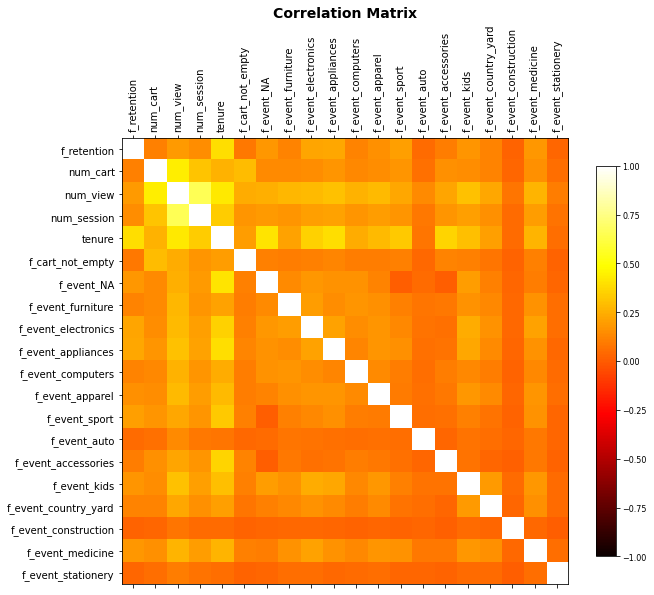

In [416]:
f = plt.figure(figsize=(10, 10))
selected_columns = df.filter(regex='^(?!f_event_20)')
plt.matshow(selected_columns.reset_index('f_retention').corr(), fignum=f.number, vmin=-1, vmax=1, cmap='hot')
plt.xticks(range(selected_columns.reset_index('f_retention').select_dtypes(['number']).shape[1]), selected_columns.reset_index('f_retention').select_dtypes(['number']).columns, fontsize=10, rotation=90)
plt.yticks(range(selected_columns.reset_index('f_retention').select_dtypes(['number']).shape[1]), selected_columns.reset_index('f_retention').select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar(shrink=0.7)
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold');

In [285]:
# Identify highly-correlated fields
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in lower.columns if any(lower[column] > 0.8)]

In [286]:
# to_drop.append('active_days')
to_drop

[]

In [298]:
df_trimmed = df.drop(to_drop, axis=1, inplace=False)
y = df_trimmed.reset_index('f_retention').f_retention
X = df_trimmed.reset_index('f_retention', drop=True)

In [299]:
assert y.shape[0] == X.shape[0]

In [300]:
y.value_counts(normalize=True)

0    0.579955
1    0.420045
Name: f_retention, dtype: float64

In [325]:
# from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123, shuffle=True, stratify=y)

# Logit model (sample)

### Grid search

In [422]:
# from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder , MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,plot_confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline

In [362]:
def eval_report(model, x, y):
    print("Accuracy score {:.2f} \n".format(accuracy_score(y, model.predict(x))))
    print("ROC AUC score {:.2f} \n".format(roc_auc_score(y, model.predict(x))))
    plot_confusion_matrix(model,x,y,cmap=plt.cm.Blues)
    print(classification_report(y,model.predict(x)))

In [347]:
# Grid search
param_grid_log = {
    'lr__C': [0.1, 1, 10, 100],
    'lr__max_iter': [200, 300],
    'lr__penalty': ['l1', 'l2'],
    'lr__tol':[0.0001],
}

log_first = Pipeline([('scaler',  StandardScaler()),
            ('lr', LogisticRegression(solver='saga'))])

log_grid = GridSearchCV(log_first, param_grid=[param_grid_log], scoring='roc_auc', cv=10, verbose=1, return_train_score=True, n_jobs=-1)
log_grid.fit(x_train, y_train)

print(f"The best parameters are: {log_grid.best_params_}")
print(f"The best model score is: {log_grid.best_score_}")    
print(f"The best estimator is: {log_grid.best_estimator_}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits
The best parameters are: {'lr__C': 0.1, 'lr__max_iter': 200, 'lr__penalty': 'l1', 'lr__tol': 0.0001}
The best model score is: 0.7625474607316736
The best estimator is: Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.1, max_iter=200, penalty='l1',
                                    solver='saga'))])


### Train set

In [356]:
# Use the best parameters found by Grid Search to fit training data
best_logit = Pipeline(steps=[('stdscale', StandardScaler()),('lr', LogisticRegression(solver='saga', 
                                                                                      penalty='l1',
                                                                                      C=0.1, max_iter=200, tol=0.0001
                                                                                     ))])
best_logit.fit(x_train, y_train)


Pipeline(steps=[('stdscale', StandardScaler()),
                ('lr',
                 LogisticRegression(C=0.1, max_iter=200, penalty='l1',
                                    solver='saga'))])

Accuracy score 0.72 

ROC AUC score 0.69 

              precision    recall  f1-score   support

           0       0.71      0.87      0.78    182260
           1       0.74      0.51      0.60    132005

    accuracy                           0.72    314265
   macro avg       0.73      0.69      0.69    314265
weighted avg       0.72      0.72      0.71    314265



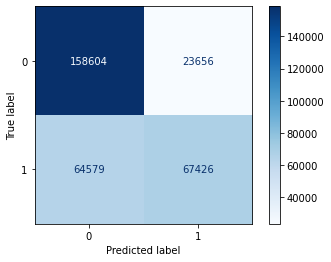

In [363]:
eval_report(best_logit, x_train, y_train)

### Test set

Accuracy score 0.72 

ROC AUC score 0.69 

              precision    recall  f1-score   support

           0       0.71      0.87      0.78     45565
           1       0.74      0.51      0.60     33002

    accuracy                           0.72     78567
   macro avg       0.72      0.69      0.69     78567
weighted avg       0.72      0.72      0.71     78567



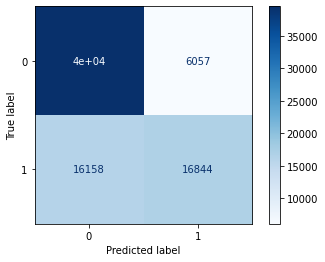

In [368]:
eval_report(best_logit, x_test, y_test)

### Feature importance

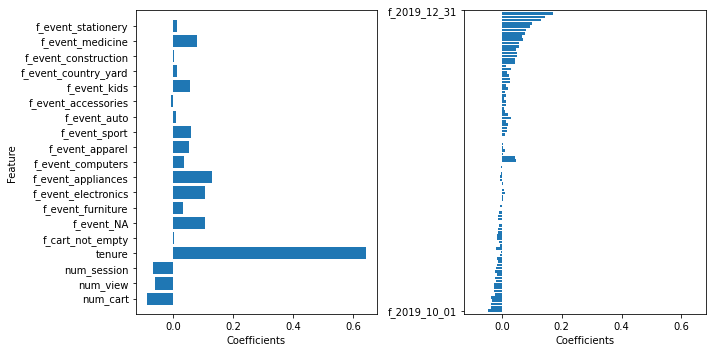

In [407]:
log_coeff = pd.concat([pd.Series(X.columns), pd.Series(best_logit.named_steps['lr'].coef_[0])], axis=1) \
    .rename(columns={0: 'feature', 1: 'coefficient'}) \
    .set_index('feature') 

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharex=True)
no_date_dummy = log_coeff.filter(regex='^(?!f_event_20)', axis=0)['coefficient']
date_dummy = log_coeff.filter(regex='^(f_event_20)', axis=0)['coefficient']

ax1.barh(range(len(no_date_dummy)), no_date_dummy, align='center')
ax1.set_yticks(np.arange(len(no_date_dummy)))
ax1.set_yticklabels(no_date_dummy.index)
ax1.set_xlabel("Coefficients")
ax1.set_ylabel("Feature")
ax1.set_ylim(-1, len(no_date_dummy));

ax2.barh(range(len(date_dummy)), date_dummy, align='center')
ax2.set_yticks([0, len(date_dummy)])
ax2.set_yticklabels(['f_2019_10_01', 'f_2019_12_31'])
ax2.set_xlabel("Coefficients")
ax2.set_ylim(-1, len(date_dummy));


plt.tight_layout()  



# Random forest

### Grid search

In [309]:
from sklearn.ensemble import RandomForestClassifier 

In [369]:
# Grid search
param_grid = {
              'max_depth': [3, 5, 6], 
              'max_features': ['sqrt', 'log2'],
              'n_estimators':[50, 100],
             }
             
random_forest = RandomForestClassifier()
random_forest_grid = GridSearchCV(random_forest, param_grid, cv=5, refit=True, verbose=3, n_jobs=-1, return_train_score=True)
random_forest_grid.fit(x_train, y_train)

print(f"The best parameters are: {random_forest_grid.best_params_}")
print(f"The best model score is: {random_forest_grid.best_score_}")    
print(f"The best estimator is: {random_forest_grid.best_estimator_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best parameters are: {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}
The best model score is: 0.7107122969468442
The best estimator is: RandomForestClassifier(max_depth=6, max_features='sqrt')


### Train set

In [370]:
# Use best parameters to train model
best_rf = RandomForestClassifier(n_jobs = -1,random_state = 123, max_depth=6, max_features='sqrt')
best_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=6, max_features='sqrt', n_jobs=-1,
                       random_state=123)

Accuracy score 0.71 

ROC AUC score 0.68 

              precision    recall  f1-score   support

           0       0.71      0.86      0.78    182260
           1       0.72      0.50      0.59    132005

    accuracy                           0.71    314265
   macro avg       0.72      0.68      0.69    314265
weighted avg       0.71      0.71      0.70    314265



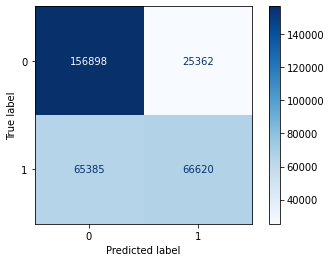

In [371]:
eval_report(best_rf, x_train, y_train)

### Test set

Accuracy score 0.71 

ROC AUC score 0.68 

              precision    recall  f1-score   support

           0       0.70      0.86      0.77     45565
           1       0.72      0.50      0.59     33002

    accuracy                           0.71     78567
   macro avg       0.71      0.68      0.68     78567
weighted avg       0.71      0.71      0.70     78567



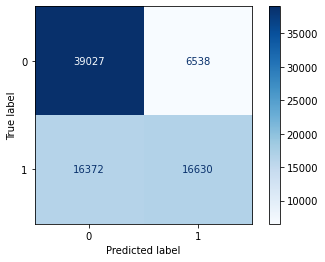

In [372]:
eval_report(best_rf, x_test, y_test)

### Feature importance

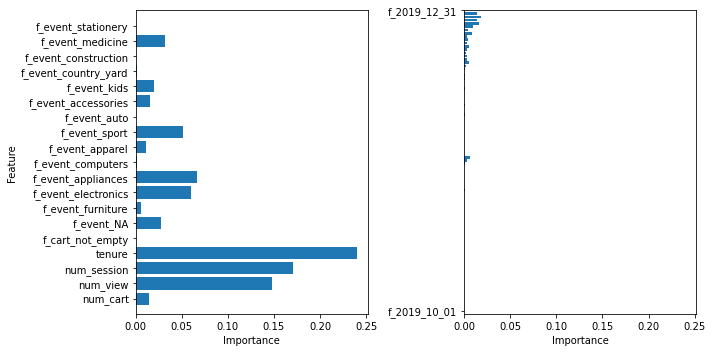

In [415]:
rf_coeff = pd.concat([pd.Series(X.columns), pd.Series(best_rf.feature_importances_)], axis=1) \
    .rename(columns={0: 'feature', 1: 'coefficient'}) \
    .set_index('feature') 

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharex=True)
no_date_dummy = rf_coeff.filter(regex='^(?!f_event_20)', axis=0)['coefficient']
date_dummy = rf_coeff.filter(regex='^(f_event_20)', axis=0)['coefficient']

ax1.barh(range(len(no_date_dummy)), no_date_dummy, align='center')
ax1.set_yticks(np.arange(len(no_date_dummy)))
ax1.set_yticklabels(no_date_dummy.index)
ax1.set_xlabel("Importance")
ax1.set_ylabel("Feature")
ax1.set_ylim(-1, len(no_date_dummy));

ax2.barh(range(len(date_dummy)), date_dummy, align='center')
ax2.set_yticks([0, len(date_dummy)])
ax2.set_yticklabels(['f_2019_10_01', 'f_2019_12_31'])
ax2.set_xlabel("Importance")
ax2.set_ylim(-1, len(date_dummy));


plt.tight_layout()  




# XG boost

### Grid search

In [597]:
!pip install xgboost

     |████████████████████████████████| 173.5 MB 41 kB/s s eta 0:00:01    |███████████████▋                | 84.3 MB 17.0 MB/s eta 0:00:06     |███████████████████████████▏    | 147.6 MB 22.9 MB/s eta 0:00:02


In [314]:
from xgboost import XGBClassifier

In [424]:
# A parameter grid for XGBoost
params = {
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 6],
        'learning_rate': [0.02, 0.04, 0.06],
        'n_estimator': [100, 300, 500]
        }

xgb = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=-1)
folds = 5
param_comb = 10

# skf = StratifiedKFold(n_splits=folds, random_state = 123)

xbg_grid = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', \
                                   n_jobs=-1, cv=5, verbose=3, random_state=123 )
xbg_grid.fit(x_train, y_train)


print(f"The best parameters are: {xbg_grid.best_params_}")
print(f"The best model score is: {xbg_grid.best_score_}")    
print(f"The best estimator is: {xbg_grid.best_estimator_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/nonroott/.conda/envs/nonrootenv/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:24:03] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:24:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The best parameters are: {'subsample': 0.8, 'n_estimator': 300, 'max_depth': 6, 'learning_rate': 0.06}
The best model score is: 0.7640637951304786
The best estimator is: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
 

Accuracy score 0.73 

ROC AUC score 0.70 

              precision    recall  f1-score   support

           0       0.72      0.85      0.78    182260
           1       0.73      0.55      0.63    132005

    accuracy                           0.73    314265
   macro avg       0.73      0.70      0.71    314265
weighted avg       0.73      0.73      0.72    314265



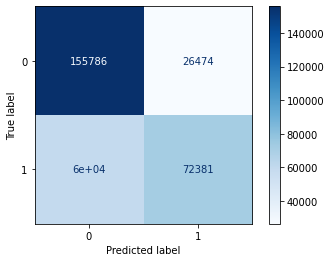

In [425]:
eval_report(xbg_grid.best_estimator_, x_train, y_train)

Accuracy score 0.72 

ROC AUC score 0.70 

              precision    recall  f1-score   support

           0       0.72      0.85      0.78     45565
           1       0.72      0.54      0.62     33002

    accuracy                           0.72     78567
   macro avg       0.72      0.70      0.70     78567
weighted avg       0.72      0.72      0.71     78567



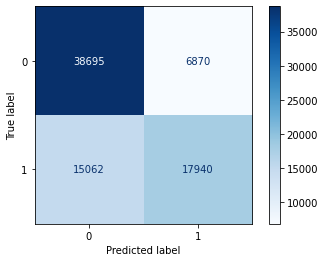

In [426]:
eval_report(xbg_grid.best_estimator_, x_test, y_test)

### Feature importance

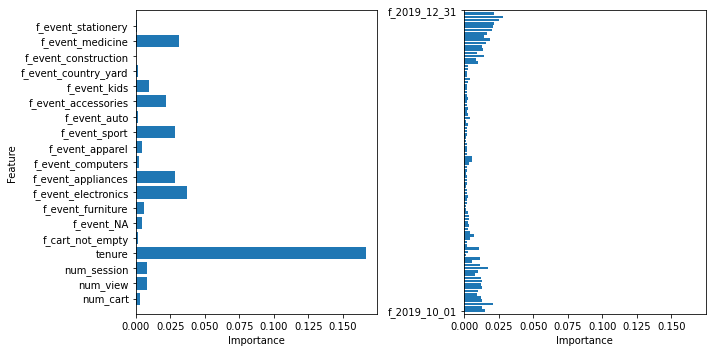

In [427]:
xgb_coeff = pd.concat([pd.Series(X.columns), pd.Series(xbg_grid.best_estimator_.feature_importances_)], axis=1) \
    .rename(columns={0: 'feature', 1: 'coefficient'}) \
    .set_index('feature') 

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5),sharex=True)
no_date_dummy = xgb_coeff.filter(regex='^(?!f_event_20)', axis=0)['coefficient']
date_dummy = xgb_coeff.filter(regex='^(f_event_20)', axis=0)['coefficient']

ax1.barh(range(len(no_date_dummy)), no_date_dummy, align='center')
ax1.set_yticks(np.arange(len(no_date_dummy)))
ax1.set_yticklabels(no_date_dummy.index)
ax1.set_xlabel("Importance")
ax1.set_ylabel("Feature")
ax1.set_ylim(-1, len(no_date_dummy));

ax2.barh(range(len(date_dummy)), date_dummy, align='center')
ax2.set_yticks([0, len(date_dummy)])
ax2.set_yticklabels(['f_2019_10_01', 'f_2019_12_31'])
ax2.set_xlabel("Importance")
ax2.set_ylim(-1, len(date_dummy));


plt.tight_layout()  





# Reference plots (not used)

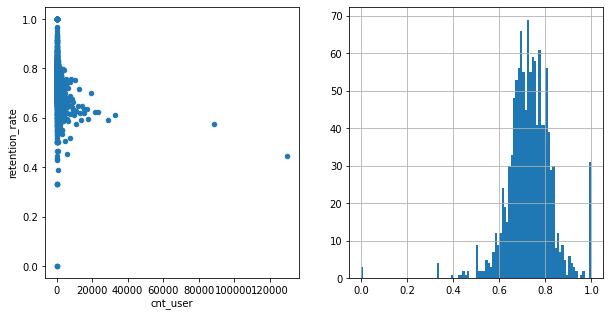

In [428]:
# df_sample.reset_index().groupby(['category_code'])[['f_retention']].mean().hist(figsize=(10,5))
# df_sample.reset_index().groupby(['category_id'])[['f_retention']].mean().hist(figsize=(10,5))
# df_sample.reset_index().groupby(['category_code'])[['f_retention']].count().hist(figsize=(10,5))
# df_sample.reset_index().groupby(['category_id_encoded'])[['f_retention']].mean().plot(figsize=(10,5))

# df_sample[['product_id', 'user_id', 'f_retention']].drop_duplicates().groupby('product_id')['f_retention'].mean().hist(figsize=(10,5))

#slide
category_check = df_sample.loc[:, ['category_id', 'user_id', 'f_retention']].drop_duplicates().groupby('category_id') \
    .agg(cnt_user=('user_id', 'nunique'), retention_rate = ('f_retention', 'mean'))

product_check = df_sample[['product_id', 'user_id', 'f_retention']].drop_duplicates().groupby('product_id') \
    .agg(cnt_user=('user_id', 'nunique'), retention_rate = ('f_retention', 'mean'))

fig, axs = plt.subplots(1,2, figsize=(10,5))

category_check.plot.scatter(x='cnt_user', y='retention_rate', ax=axs[0]);
# plt.xlim([0, 1000]);

category_check \
    ['retention_rate'].hist(bins=100, ax=axs[1]);


<AxesSubplot:xlabel='event_date'>

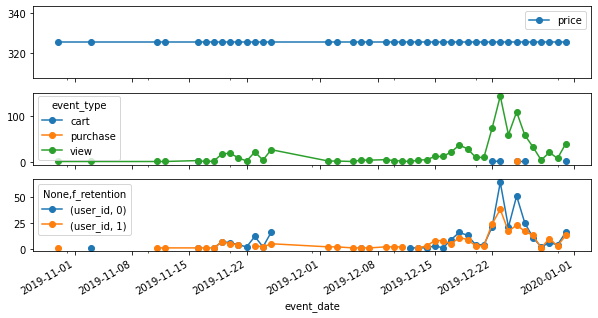

In [554]:
fig, axs = plt.subplots(3,1,sharex=True, figsize=(10,5))
product_id_sample = 26400756
df_sample.loc[df_sample.product_id == product_id_sample, ['event_date', 'price']].drop_duplicates().set_index('event_date').plot(ax=axs[0], marker='o')
df_sample.loc[(df_sample.product_id == product_id_sample)].groupby(['event_date', 'event_type']).size().unstack('event_type').plot(ax=axs[1], marker='o')
df_sample.loc[(df_sample.product_id == product_id_sample)].groupby(['event_date', 'f_retention']).agg({'user_id': 'nunique'}).unstack('f_retention').plot(ax=axs[2], marker='o')

# plt.xlim([pd.to_datetime('2019-11-10'), pd.to_datetime('2019-11-25')])